In [77]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [78]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1049 non-null   object 
 1   SeasonNumber       1049 non-null   int64  
 2   SeasonVersion      1049 non-null   int64  
 3   Player             1049 non-null   object 
 4   MatchId            1049 non-null   object 
 5   Map                1049 non-null   object 
 6   Category           1049 non-null   object 
 7   Playlist           1049 non-null   object 
 8   Input              1049 non-null   object 
 9   Queue              1049 non-null   object 
 10  PreCsr             1049 non-null   int64  
 11  PostCsr            1049 non-null   int64  
 12  Rank               1049 non-null   int64  
 13  WasAtStart         1049 non-null   int64  
 14  WasAtEnd           1049 non-null   int64  
 15  WasInProgressJoin  1049 non-null   int64  
 16  Mmr                2 non

In [79]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/Life'] = df['DamageDone'] / df['Deaths'].replace(0,1)
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 140 to 1048
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         772 non-null    int64  
 1   Accuracy        772 non-null    float64
 2   DamageDone      772 non-null    int64  
 3   DamageTaken     772 non-null    int64  
 4   KD              772 non-null    float64
 5   KDA             772 non-null    float64
 6   Kills           772 non-null    int64  
 7   Deaths          772 non-null    int64  
 8   Assists         772 non-null    int64  
 9   MaxSpree        772 non-null    int64  
 10  ExpectedKills   772 non-null    float64
 11  ExpectedDeaths  772 non-null    float64
 12  Score           772 non-null    int64  
 13  Medals          772 non-null    int64  
 14  LengthMinutes   772 non-null    float64
 15  DamageRatio     772 non-null    float64
 16  Damage/Kill     772 non-null    float64
 17  Damage/Life     772 non-null    

In [80]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [81]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.439994
DmgT/10Min        0.366231
Damage/Life       0.328103
Deaths            0.325419
KD                0.324496
KDA               0.290496
Damage/KA         0.287875
DamageTaken       0.258675
ExcessDeaths      0.256634
ExpectedDeaths    0.217390
Damage/Kill       0.189695
Assists/10Min     0.169679
Kills/10Min       0.154174
LengthMinutes     0.143697
DamageDone        0.098244
Accuracy          0.091578
MaxSpree          0.080711
Assists           0.052250
ExpectedKills     0.043655
HSPct             0.040959
BodyPct           0.038963
DamageRatio       0.036700
Score             0.033007
Dmg/10Min         0.031285
ExcessKills       0.028279
PowerPct          0.020784
Kills             0.012553
GrenadePct        0.009421
Medals            0.008287
Shots/10Min       0.004166
MeleePct          0.002571
Name: Outcome, dtype: float64


In [82]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [83]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,772.0,0.551813,0.497631,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,772.0,52.762837,5.529685,20.450000,49.327500,52.800000,56.135000,80.560000
DamageDone,772.0,5282.861399,1801.103309,619.000000,3924.250000,5058.000000,6505.000000,12673.000000
DamageTaken,772.0,4531.163212,1534.477929,0.000000,3488.750000,4363.000000,5565.500000,9962.000000
KD,772.0,1.266813,0.739416,0.270000,0.850000,1.120000,1.460000,10.000000
KDA,772.0,4.494650,5.713476,-10.000000,0.660000,4.330000,8.000000,31.000000
Kills,772.0,14.549223,6.222541,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,772.0,12.928756,5.115157,0.000000,9.000000,13.000000,16.000000,32.000000
Assists,772.0,8.628238,4.258554,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,772.0,3.937824,1.598076,1.000000,3.000000,4.000000,5.000000,12.000000


In [84]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [85]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (772, 31)
Y Shape: (772,)


In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (617, 31)
X Test Shape: (155, 31)
Y Train Mean: 0.54
Y Test Mean: 0.6


In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 'Damage/Life',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)


print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')
# X_train_preprocessed.head()

X Train Processed Shape: (617, 31)
X Train Shape: (617, 31)
X Test Processed Shape: (155, 31)


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [89]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.8
Acc: 0.800
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.17
OOS R^2 Score: 0.18
Log Loss: 7.21
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        62
           1       0.86      0.80      0.83        93

    accuracy                           0.80       155
   macro avg       0.79      0.80      0.80       155
weighted avg       0.81      0.80      0.80       155

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: -0.02
MeleePct: -0.03
BodyPct: 0.04
Damage/Kill: -0.05
HSPct: -0.06
PowerPct: -0.08
Shots/10Min: -0.08
GrenadePct: 0.12
Damage/Life: -0.14
KDA: -0.15
None


## Ridge

In [90]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8
   C_param  Accuracy
0    0.001  0.674325
1    0.010  0.731012
2    0.100  0.802255
3    1.000  0.808773
4   10.000  0.810399
5  100.000  0.810399

Acc: 0.800
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.17
OOS R^2 Score: 0.18
Log Loss: 7.21
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        62
           1       0.85      0.81      0.83        93

    accuracy                           0.80       155
   macro avg       0.79      0.80      0.79       155
weighted avg       0.80      0.80      0.80       155

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
MeleePct: -0.01
DamageRatio: -0.03
BodyPct: 0.03
HSPct: -0.03
Medals: 0.04
Assists/10Min: 0.04
Assists: -0.05
Dmg/10Min: -0.06
Shots/10Min: -0.07
ExpectedKills: 0.08
None


## Lasso

In [91]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.7935483870967742
   C_param  Accuracy
0    0.001  0.539706
1    0.010  0.575295
2    0.100  0.765041
3    1.000  0.812025
4   10.000  0.810399
5  100.000  0.808773

Acc: 0.794
MAE: 0.21
MSE: 0.21
RMSE: 0.45
R^2 Score: 0.14
OOS R^2 Score: 0.15
Log Loss: 7.44
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        62
           1       0.84      0.81      0.82        93

    accuracy                           0.79       155
   macro avg       0.78      0.79      0.79       155
weighted avg       0.80      0.79      0.79       155

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Assists: 0.00
ExpectedKills: 0.00
ExpectedDeaths: 0.00
DamageRatio: 0.00
Assists/10Min: 0.00
Dmg/10Min: 0.00
MeleePct: -0.00
MaxSpree: 0.00
Medals: 0.01
BodyPct: 0.02
None


## ElasticNet

In [92]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=1, l1_ratio=0.75, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.7935483870967742
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.539706
1     0.001            0.50  0.539706
2     0.001            0.75  0.539706
3     0.010            0.25  0.714805
4     0.010            0.50  0.703488
5     0.010            0.75  0.667768
6     0.100            0.25  0.786074
7     0.100            0.50  0.781222
8     0.100            0.75  0.773145
9     1.000            0.25  0.810412
10    1.000            0.50  0.810412
11    1.000            0.75  0.812025
12   10.000            0.25  0.810399
13   10.000            0.50  0.810399
14   10.000            0.75  0.810399
15  100.000            0.25  0.810399
16  100.000            0.50  0.810399
17  100.000            0.75  0.810399

Acc: 0.794
MAE: 0.21
MSE: 0.21
RMSE: 0.45
R^2 Score: 0.14
OOS R^2 Score: 0.15
Log Loss: 7.44
---------------------------------------------------------
          

## K-Nearest Neighbours

In [93]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=16)
K-Nearest Neighbors Accuracy: 0.6967741935483871
    n_neighbors_param  Accuracy
0                   1  0.651469
1                   4  0.674325
2                   7  0.680842
3                  10  0.697036
4                  13  0.714831
5                  16  0.719643
6                  19  0.716391
7                  22  0.716444
8                  25  0.713139
9                  28  0.708340
10                 31  0.698597
11                 34  0.705114
12                 37  0.697023
13                 40  0.705101
14                 43  0.685694
15                 46  0.688946
16                 49  0.692158

Acc: 0.697
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.26
OOS R^2 Score: -0.24
Log Loss: 10.93
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        62
           1       0.77      0.70      0.73        93

    accuracy       

## Random Forest

In [94]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, random_state=69)
Random Forest Accuracy: 0.7354838709677419
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.734264
1               10                 300  0.726147
2               10                 500  0.726121
3               15                 100  0.708301
4               15                 300  0.711526
5               15                 500  0.714765
6               20                 100  0.718030
7               20                 300  0.711526
8               20                 500  0.718004


''

In [95]:
ResultsOut(rf_cv)

Acc: 0.735
MAE: 0.26
MSE: 0.26
RMSE: 0.51
R^2 Score: -0.10
OOS R^2 Score: -0.09
Log Loss: 9.53
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        62
           1       0.78      0.77      0.78        93

    accuracy                           0.74       155
   macro avg       0.72      0.73      0.73       155
weighted avg       0.74      0.74      0.74       155

---------------------------------------------------------


''

<Axes: >

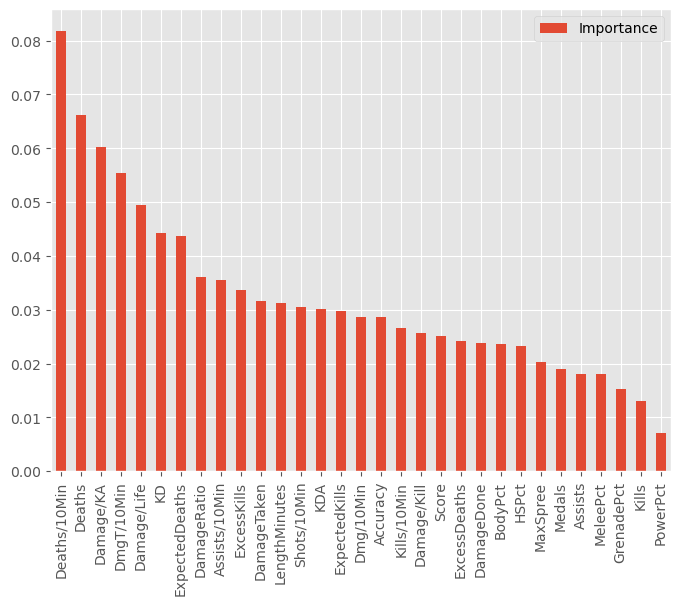

In [96]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [97]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=500,
                           random_state=69, subsample=0.6)
Gradient Boosed Trees Accuracy: 0.7225806451612903
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70

''

In [98]:
ResultsOut(GBRT)

Acc: 0.723
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.16
OOS R^2 Score: -0.14
Log Loss: 10.00
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.66      0.66        62
           1       0.77      0.76      0.77        93

    accuracy                           0.72       155
   macro avg       0.71      0.71      0.71       155
weighted avg       0.72      0.72      0.72       155

---------------------------------------------------------


''

<Axes: >

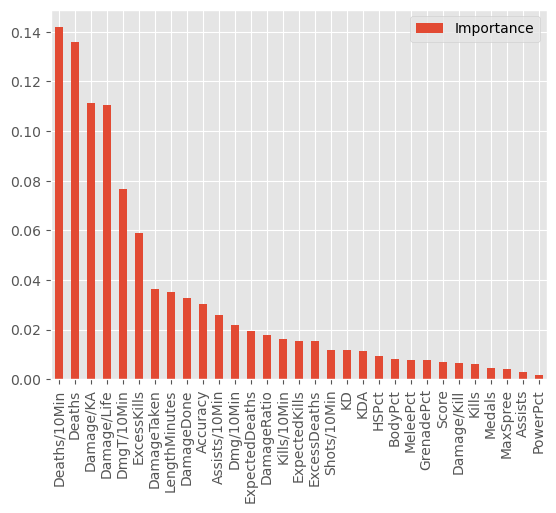

In [99]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [100]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [100,200,300,400,500],'learning_rate': [0.01,0.05,0.1,0.15],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.6967741935483871
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                  0.01                1                 100  0.684055
1                  0.01                1                 200  0.700184
2   

''

In [101]:
ResultsOut(XGB)

Acc: 0.697
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.26
OOS R^2 Score: -0.24
Log Loss: 10.93
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.58      0.61        62
           1       0.73      0.77      0.75        93

    accuracy                           0.70       155
   macro avg       0.68      0.68      0.68       155
weighted avg       0.69      0.70      0.69       155

---------------------------------------------------------


''

<Axes: >

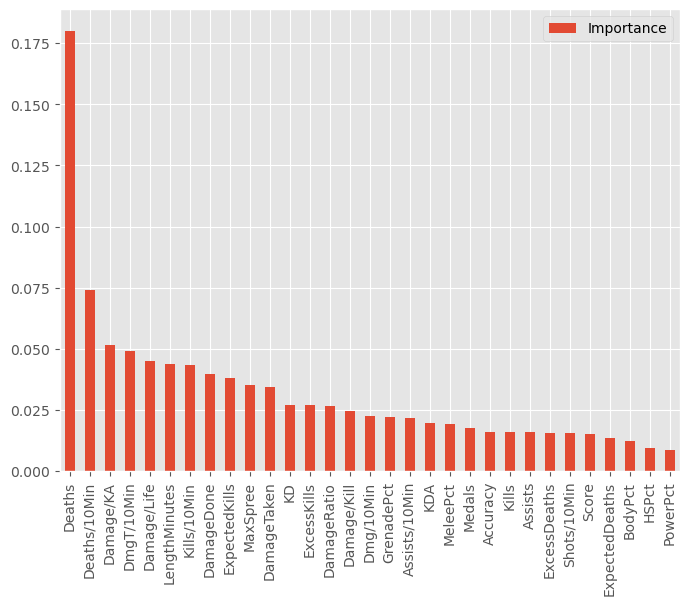

In [102]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:31], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [103]:
from sklearn.neural_network import MLPClassifier

param_grid_mlpc = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
mlpc = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_mlpc, n_jobs=-1)

mlpc.fit(X_train_preprocessed, y_train)
print(mlpc.best_estimator_)
print(f'Neural Net Accuracy: {mlpc.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

MLPClassifier(activation='logistic', alpha=0.01, random_state=61)
Neural Net Accuracy: 0.7741935483870968


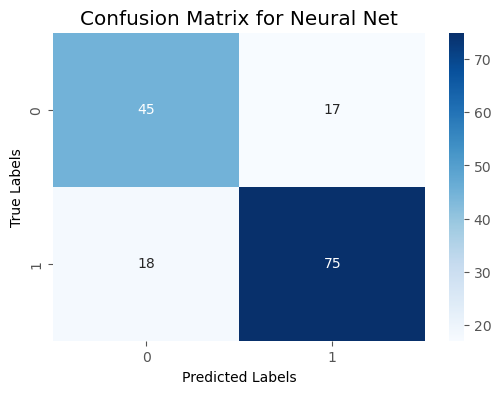

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

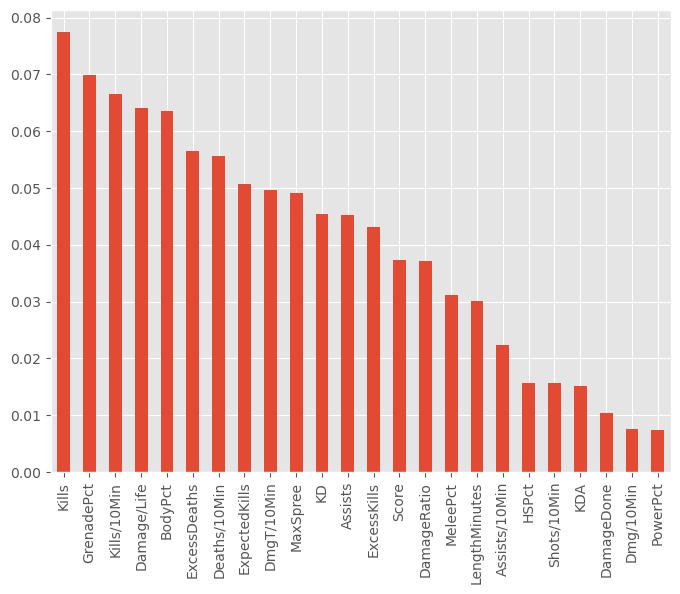

In [104]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, mlpc.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(mlpc.best_estimator_.coefs_[0].flatten()[:31], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch NN

In [105]:
# y_train.shape

In [106]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Assuming X_train_preprocessed and y_train are your NumPy arrays
# y_train_array = y_train.values
# X_train_preprocessed_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float)
# y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

# # Instantiate the model
# input_size = 30  # Replace with the actual input size
# hidden_size = 15 # Replace with the desired hidden layer size
# output_size = 2  # Replace with the actual output size
# model = SimpleNeuralNet(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Train the model on your trainsets
# # Replace X_train and y_train with your actual train data
# # Replace num_epochs with the desired number of training epochs
# losses = []
# accuracies = []
# prev_loss = float('inf')
# for epoch in range(100000):
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     if loss >= prev_loss:
#         break
#     prev_loss = loss
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
    
#     # Calculate training accuracy
#     with torch.no_grad():
#         predicted = torch.argmax(outputs, 1)
#         correct = (predicted == y_train_tensor).sum().item()
#         accuracy = correct / y_train_tensor.size(0)
#         accuracies.append(accuracy)

In [107]:
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)

# def closure():
#     optimizer.zero_grad()
#     outputs = model(X_train_preprocessed_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     return loss

# # Train the model using the LBFGS optimizer with the closure function
# for epoch in range(100000):
#     optimizer.step(closure)

In [108]:
# # Assuming X_test_preprocessed and y_test are your test data
# X_test_preprocessed_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# # Evaluate the model on the test set
# with torch.no_grad():
#     test_outputs = model(X_test_preprocessed_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     test_predicted = torch.argmax(test_outputs, 1)
#     test_correct = (test_predicted == y_test_tensor).sum().item()
#     test_accuracy = test_correct / y_test_tensor.size(0)

# print(f'Test Loss: {test_loss.item()}')
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Epochs: {len(losses)}')

In [109]:
# import matplotlib.pyplot as plt
# epochs = range(1, len(losses) + 1)

# # Plotting training and validation losses
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, losses, label='Training Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plotting training and validation accuracies
# plt.subplot(1, 2, 2)
# plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.title('Training and Validation Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Logistic Regression,0.800,0.200,0.200,0.447,0.167,0.179,7.209
1,Ridge,0.800,0.200,0.200,0.447,0.167,0.179,7.209
2,Lasso,0.794,0.206,0.206,0.454,0.140,0.153,7.441
3,ElasticNet,0.794,0.206,0.206,0.454,0.140,0.153,7.441
4,MLPC,0.774,0.226,0.226,0.475,0.059,0.073,8.139
5,Random Forest,0.735,0.265,0.265,0.514,-0.102,-0.086,9.534
6,Gradient Boosted Trees,0.723,0.277,0.277,0.527,-0.156,-0.139,9.999
7,K-Nearest Neighbors,0.697,0.303,0.303,0.551,-0.263,-0.245,10.929
8,XGBoost,0.697,0.303,0.303,0.551,-0.263,-0.245,10.929


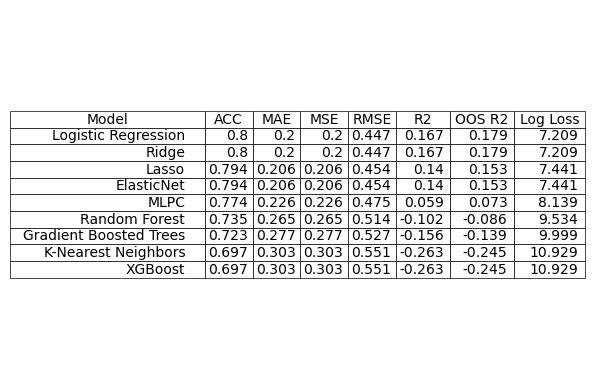

In [110]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,mlpc]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'MLPC']
from datetime import datetime
date = datetime.now().strftime("%m%d")

def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig(f'ModelResults/ModelResults{date}.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


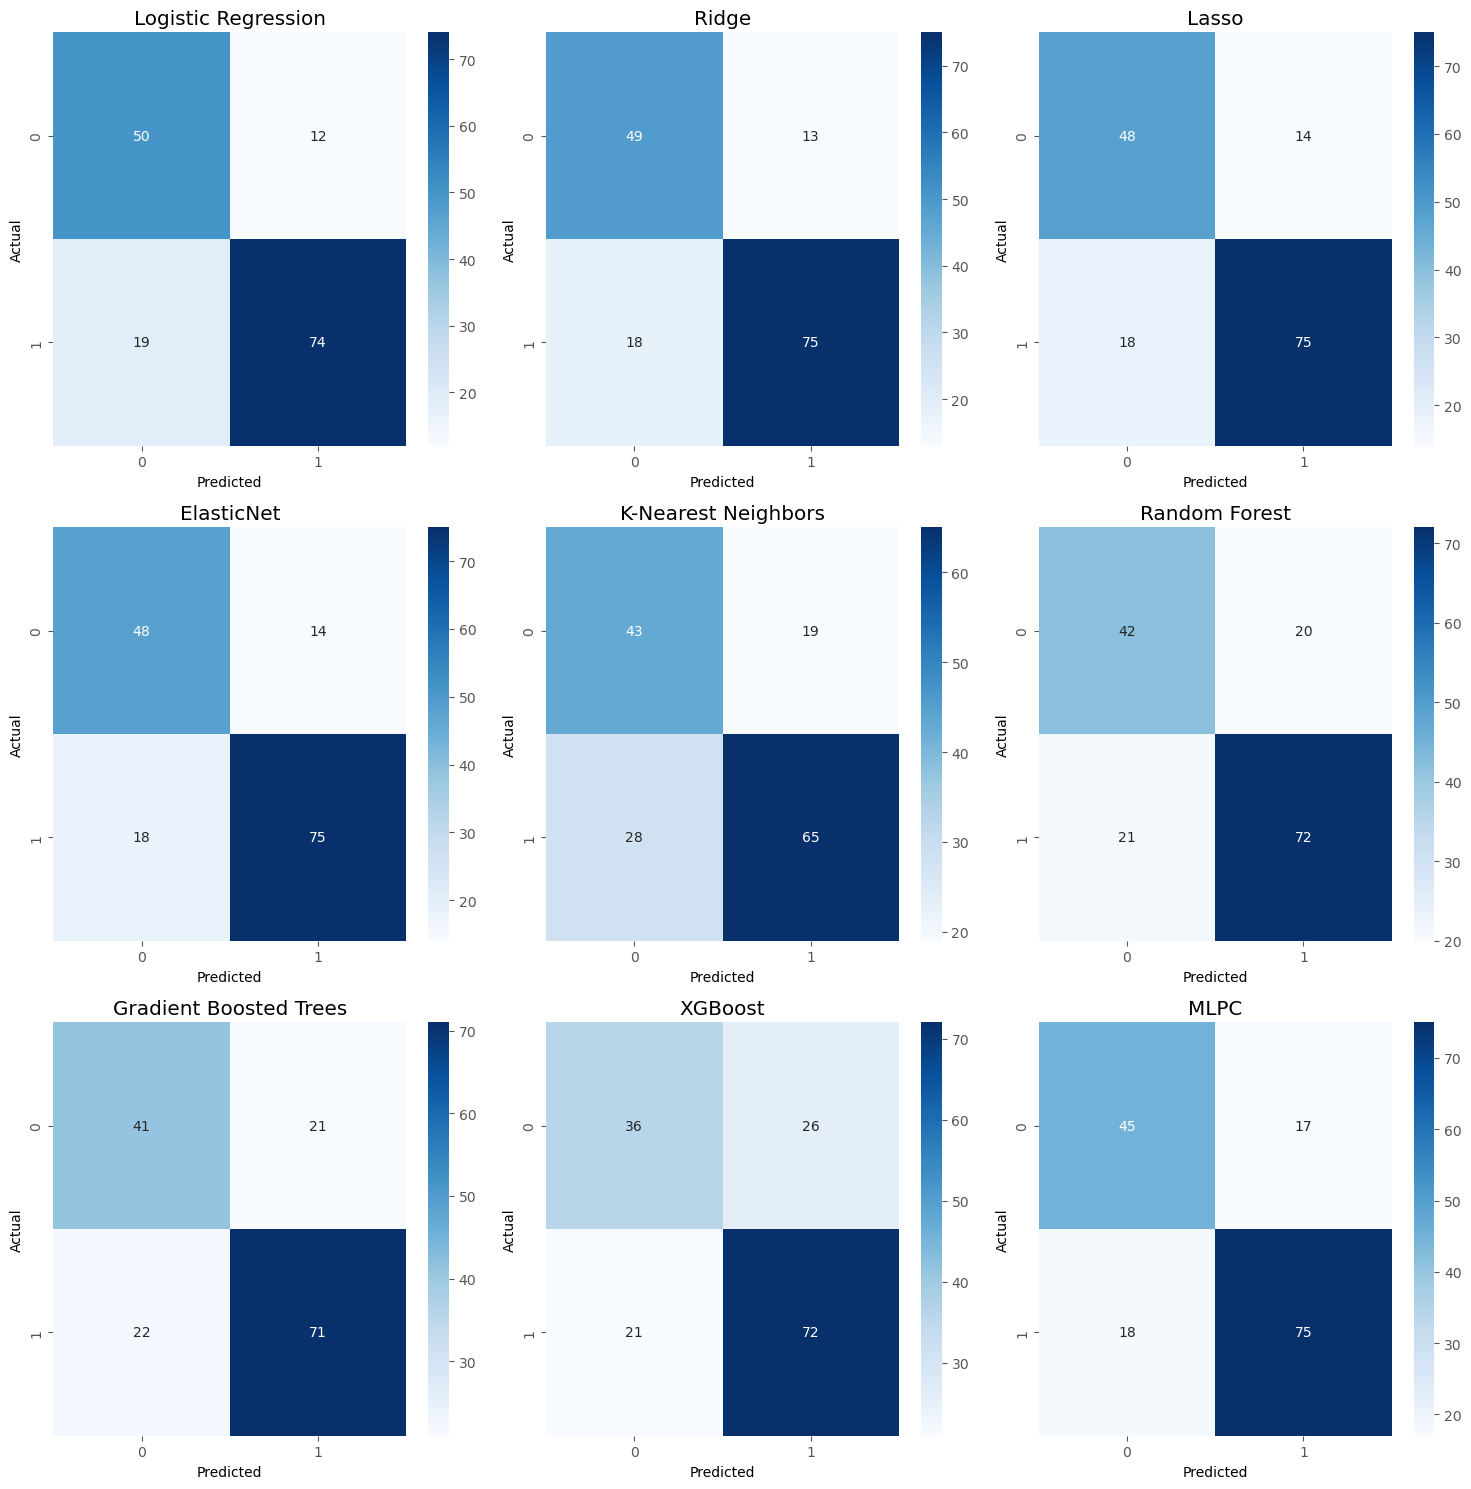

In [111]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(f'Plots/ConfusionMatrixMultigraph{date}.png', dpi=300, bbox_inches='tight')
plt.show()

In [112]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 177.62s


In [113]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,617.0,-0.0,1.001,-0.060,-0.047,-0.042,-0.036,24.818
Damage/KA,617.0,0.0,1.001,-1.254,-0.561,-0.192,0.239,11.516
KD,617.0,-0.0,1.001,-1.298,-0.575,-0.207,0.254,11.496
PowerPct,617.0,-0.0,1.001,-0.351,-0.351,-0.351,-0.351,6.714
Damage/Kill,617.0,0.0,1.001,-1.912,-0.674,-0.220,0.413,6.354
Shots/10Min,617.0,0.0,1.001,-3.625,-0.606,-0.007,0.588,5.985
Damage/Life,617.0,0.0,1.001,-2.126,-0.700,-0.137,0.511,5.535
Kills,617.0,0.0,1.001,-1.845,-0.589,0.040,0.668,5.067
Assists/10Min,617.0,0.0,1.001,-2.554,-0.697,-0.066,0.590,5.047
Accuracy,617.0,0.0,1.001,-5.723,-0.592,-0.013,0.587,4.967
